# Classification

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (confusion_matrix, classification_report, RocCurveDisplay, roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)

from sklearn.decomposition import PCA
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from imblearn.over_sampling import SMOTE

pd.set_option('display.max_rows', 500)

In [2]:
# Import datasets
df_radiomics = pd.read_excel('data/complete_df.xlsx')
df_radiomics.head()

,classe_name,patient_num,Gender,Age_at_disease,Alpha_foetoprotein,Local_relapse,Distant_relapse,Death,Date_of_lost_of_FU,survival_time,...,original_glszm_SmallAreaHighGrayLevelEmphasis_TARD,original_glszm_SmallAreaLowGrayLevelEmphasis_TARD,original_glszm_ZoneEntropy_TARD,original_glszm_ZonePercentage_TARD,original_glszm_ZoneVariance_TARD,original_ngtdm_Busyness_TARD,original_ngtdm_Coarseness_TARD,original_ngtdm_Complexity_TARD,original_ngtdm_Contrast_TARD,original_ngtdm_Strength_TARD
0,0,10,1,62.0,NaN,0,0,1,NaT,133.0,...,33.413109,0.009836,6.090384,0.166814,87.980503,1.770498,0.003704,39.277987,0.015188,0.332041
1,0,11,0,57.0,6.1,0,0,0,2017-06-08,NaN,...,712.327011,0.007341,6.313498,0.841126,0.268177,0.163645,0.004702,11442.875990,0.449753,9.512513
2,0,12,1,58.0,1.4,0,1,1,NaT,1812.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,13,1,65.0,0.0,0,1,1,NaT,2089.0,...,11.427517,0.035033,5.902304,0.066641,2534.900063,29.486908,0.000621,13.679928,0.009523,0.023968
4,0,14,1,64.0,0.0,0,0,1,NaT,11.0,...,2.908817,0.138365,4.091810,0.059633,762.292899,7.167425,0.011379,1.508313,0.013621,0.061704


In [3]:
data_n = df_radiomics.select_dtypes(include=['float64','int64','bool'])
data_del = df_radiomics.select_dtypes(include=['datetime64','object'])
#data = data_n.T.drop_duplicates().T
data = data_n.dropna(axis=1, how='all')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Columns: 442 entries, classe_name to original_ngtdm_Strength_TARD
dtypes: bool(2), float64(434), int64(6)
memory usage: 505.7 KB


In [4]:
X_init = data.drop(columns=['dead_after_one_year', 'dead_after_six_year','patient_num','survival_time','Death','distant_relapse_time','local_relapse_time','Distant_relapse','Local_relapse'])
imp = IterativeImputer(max_iter=10, random_state=42)
df_imputed = imp.fit_transform(X_init)
original_columns = X_init.columns.tolist()
X = pd.DataFrame(df_imputed, columns=range(1, len(X_init.columns) + 1))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=range(1, len(X_init.columns) + 1),index=X_init.index)

In [5]:
X_original_col = pd.DataFrame(X_scaled, columns=original_columns,index=X_init.index)

In [6]:
X_original_col.info()
X_original_col.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Columns: 433 entries, classe_name to original_ngtdm_Strength_TARD
dtypes: float64(433)
memory usage: 497.4 KB


,classe_name,Gender,Age_at_disease,Alpha_foetoprotein,censorship_time,original_firstorder_10Percentile_ART,original_firstorder_90Percentile_ART,original_firstorder_Energy_ART,original_firstorder_Entropy_ART,original_firstorder_InterquartileRange_ART,...,original_glszm_SmallAreaHighGrayLevelEmphasis_TARD,original_glszm_SmallAreaLowGrayLevelEmphasis_TARD,original_glszm_ZoneEntropy_TARD,original_glszm_ZonePercentage_TARD,original_glszm_ZoneVariance_TARD,original_ngtdm_Busyness_TARD,original_ngtdm_Coarseness_TARD,original_ngtdm_Complexity_TARD,original_ngtdm_Contrast_TARD,original_ngtdm_Strength_TARD
0,-1.73369,0.510831,-0.014690,-0.155957,-0.036886,0.057779,0.105982,-0.183445,0.623743,0.335063,...,-0.153187,0.065268,0.586421,0.047520,-0.349568,-0.571272,-0.027756,-0.170140,-0.031927,-0.164604
1,-1.73369,-1.697761,-0.432703,-0.191678,-0.726943,0.257586,1.489586,-0.139128,2.318971,4.114009,...,1.339157,0.065234,0.824223,0.348132,-0.390495,-0.641215,-0.027665,3.485733,1.156538,2.649545
2,-1.73369,0.510831,-0.349101,-0.191851,0.026933,-0.076511,-0.206445,-0.175037,-0.307842,-0.409136,...,0.047874,-2.447297,0.742399,-2.604361,-0.027290,-0.124276,1.401036,0.002945,-0.783581,0.089089
3,-1.73369,0.510831,0.236117,-0.191903,-0.103042,-0.528212,-0.566129,-0.201586,-0.759879,-0.604336,...,-0.201515,0.065612,0.385960,0.002862,0.792185,0.635172,-0.028035,-0.178347,-0.047419,-0.259040
4,-1.73369,0.510831,0.152515,-0.191903,-0.048128,-0.353229,-0.421730,-0.212417,-0.512066,-0.494536,...,-0.220240,0.067021,-1.543719,-0.000262,-0.034928,-0.336354,-0.027059,-0.182249,-0.036213,-0.247472


## PCA

### PCA One Year

In [7]:
y = data['dead_after_one_year']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test_selected_df = pca.transform(X_test)

X_train_SMOTE, y_train_SMOTE = X_train, y_train 

#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#### Model Preparation

In [9]:
# Instiantiate models
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'dt': DecisionTreeClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'svc': SVC(random_state=42, probability=True),
          'xgb': xgb.XGBClassifier(random_state=42)
        }

In [10]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False, mission = 'After one year'):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train_SMOTE, y_train_SMOTE)
        pipe = gs
        
    else:
        pipe.fit(X_train_SMOTE, y_train_SMOTE)
    

    # Retrieve metrics
    predictions = pipe.predict(X_test_selected_df)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test_selected_df)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train_SMOTE)[:,1]


    results['model'] = mod
    results['mission'] = mission
    results['train_auc'] = roc_auc_score(y_train_SMOTE, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['precision'] = precision_score(y_test, predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)

    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [11]:
def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = RocCurveDisplay.from_estimator(m, X_test_selected_df, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('lightgrey')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

#### Realisation

In [12]:
init_list=[]
lr_1y = run_model('lr',mission='After one years')
dt_1y = run_model('dt',mission='After one years')
rf_1y = run_model('rf',mission='After one years')
gb_1y = run_model('gb',mission='After one years')
et_1y = run_model('et',mission='After one years')
svc_1y = run_model('svc',mission='After one years')
ada_1y = run_model('ada',mission='After one years')
xg_1y = run_model('xgb',mission='After one years')

### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'model': 'lr',
 'mission': 'After one years',
 'train_auc': 0.8222222222222222,
 'test_auc': 0.195,
 'precision': 0.0,
 'specificity': 1.0,
 'recall': 0.0,
 'f_score': 0.0}

True Negatives: 40
False Positives: 0
False Negatives: 5
True Positives: 0
### METRICS ###


{'model': 'dt',
 'mission': 'After one years',
 'train_auc': 1.0,
 'test_auc': 0.4125,
 'precision': 0.0,
 'specificity': 0.825,
 'recall': 0.0,
 'f_score': 0.0}

True Negatives: 33
False Positives: 7
False Negatives: 5
True Positives: 0
### METRICS ###


{'model': 'rf',
 'mission': 'After one years',
 'train_auc': 1.0,
 'test_auc': 0.27499999999999997,
 'precision': 0.0,
 'specificity': 0.975,
 'recall': 0.0,
 'f_score': 0.0}

True Negatives: 39
False Positives: 1
False Negatives: 5
True Positives: 0
### METRICS ###


{'model': 'gb',
 'mission': 'After one years',
 'train_auc': 1.0,
 'test_auc': 0.20500000000000002,
 'precision': 0.0,
 'specificity': 0.95,
 'recall': 0.0,
 'f_score': 0.0}

True Negatives: 38
False Positives: 2
False Negatives: 5
True Positives: 0
### METRICS ###


{'model': 'et',
 'mission': 'After one years',
 'train_auc': 1.0,
 'test_auc': 0.34750000000000003,
 'precision': 0.0,
 'specificity': 0.975,
 'recall': 0.0,
 'f_score': 0.0}

True Negatives: 39
False Positives: 1
False Negatives: 5
True Positives: 0
### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'model': 'svc',
 'mission': 'After one years',
 'train_auc': 0.05185185185185185,
 'test_auc': 0.42500000000000004,
 'precision': 0.0,
 'specificity': 1.0,
 'recall': 0.0,
 'f_score': 0.0}

True Negatives: 40
False Positives: 0
False Negatives: 5
True Positives: 0
### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'model': 'ada',
 'mission': 'After one years',
 'train_auc': 1.0,
 'test_auc': 0.30000000000000004,
 'precision': 0.0,
 'specificity': 0.95,
 'recall': 0.0,
 'f_score': 0.0}

True Negatives: 38
False Positives: 2
False Negatives: 5
True Positives: 0
### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'model': 'xgb',
 'mission': 'After one years',
 'train_auc': 1.0,
 'test_auc': 0.215,
 'precision': 0.0,
 'specificity': 1.0,
 'recall': 0.0,
 'f_score': 0.0}

True Negatives: 40
False Positives: 0
False Negatives: 5
True Positives: 0


In [13]:
pd.DataFrame(init_list).sort_values(by=['test_auc','mission'], ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,svc,After one years,0.051852,0.4250,0.0,1.000,0.0,0.0
1,dt,After one years,1.000000,0.4125,0.0,0.825,0.0,0.0
2,et,After one years,1.000000,0.3475,0.0,0.975,0.0,0.0
3,ada,After one years,1.000000,0.3000,0.0,0.950,0.0,0.0
4,rf,After one years,1.000000,0.2750,0.0,0.975,0.0,0.0
5,xgb,After one years,1.000000,0.2150,0.0,1.000,0.0,0.0
6,gb,After one years,1.000000,0.2050,0.0,0.950,0.0,0.0
7,lr,After one years,0.822222,0.1950,0.0,1.000,0.0,0.0


### PCA Six Years

In [14]:
y = data['dead_after_six_year']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test_selected_df = pca.transform(X_test)

X_train_SMOTE, y_train_SMOTE = X_train, y_train 

#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [16]:
init_list=[]
lr_6y = run_model('lr',mission='After six years')
dt_6y = run_model('dt',mission='After six years')
rf_6y = run_model('rf',mission='After six years')
gb_6y = run_model('gb',mission='After six years')
et_6y = run_model('et',mission='After six years')
svc_6y = run_model('svc',mission='After six years')
ada_6y = run_model('ada',mission='After six years')
xg_6y = run_model('xgb',mission='After six years')

### METRICS ###


{'model': 'lr',
 'mission': 'After six years',
 'train_auc': 0.7580357142857143,
 'test_auc': 0.47004608294930883,
 'precision': 0.6,
 'specificity': 0.9354838709677419,
 'recall': 0.21428571428571427,
 'f_score': 0.3157894736842105}

True Negatives: 29
False Positives: 2
False Negatives: 11
True Positives: 3
### METRICS ###


{'model': 'dt',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.5495391705069125,
 'precision': 0.38461538461538464,
 'specificity': 0.7419354838709677,
 'recall': 0.35714285714285715,
 'f_score': 0.37037037037037035}

True Negatives: 23
False Positives: 8
False Negatives: 9
True Positives: 5
### METRICS ###


{'model': 'rf',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.4608294930875576,
 'precision': 0.375,
 'specificity': 0.8387096774193549,
 'recall': 0.21428571428571427,
 'f_score': 0.2727272727272727}

True Negatives: 26
False Positives: 5
False Negatives: 11
True Positives: 3
### METRICS ###


{'model': 'gb',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.467741935483871,
 'precision': 0.2,
 'specificity': 0.7419354838709677,
 'recall': 0.14285714285714285,
 'f_score': 0.16666666666666666}

True Negatives: 23
False Positives: 8
False Negatives: 12
True Positives: 2
### METRICS ###


{'model': 'et',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.4481566820276498,
 'precision': 0.36363636363636365,
 'specificity': 0.7741935483870968,
 'recall': 0.2857142857142857,
 'f_score': 0.32}

True Negatives: 24
False Positives: 7
False Negatives: 10
True Positives: 4
### METRICS ###


{'model': 'svc',
 'mission': 'After six years',
 'train_auc': 0.22812500000000002,
 'test_auc': 0.4907834101382489,
 'precision': 0.0,
 'specificity': 0.967741935483871,
 'recall': 0.0,
 'f_score': 0.0}

True Negatives: 30
False Positives: 1
False Negatives: 14
True Positives: 0
### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'model': 'ada',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.5115207373271888,
 'precision': 0.45454545454545453,
 'specificity': 0.8064516129032258,
 'recall': 0.35714285714285715,
 'f_score': 0.4}

True Negatives: 25
False Positives: 6
False Negatives: 9
True Positives: 5
### METRICS ###


{'model': 'xgb',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.467741935483871,
 'precision': 0.3,
 'specificity': 0.7741935483870968,
 'recall': 0.21428571428571427,
 'f_score': 0.25}

True Negatives: 24
False Positives: 7
False Negatives: 11
True Positives: 3


In [17]:
pd.DataFrame(init_list).sort_values(by=['test_auc','mission'], ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,dt,After six years,1.000000,0.549539,0.384615,0.741935,0.357143,0.370370
1,ada,After six years,1.000000,0.511521,0.454545,0.806452,0.357143,0.400000
2,svc,After six years,0.228125,0.490783,0.000000,0.967742,0.000000,0.000000
3,lr,After six years,0.758036,0.470046,0.600000,0.935484,0.214286,0.315789
4,gb,After six years,1.000000,0.467742,0.200000,0.741935,0.142857,0.166667
5,xgb,After six years,1.000000,0.467742,0.300000,0.774194,0.214286,0.250000
6,rf,After six years,1.000000,0.460829,0.375000,0.838710,0.214286,0.272727
7,et,After six years,1.000000,0.448157,0.363636,0.774194,0.285714,0.320000


## SelectKBest

### One Year

In [18]:
y = data['dead_after_one_year']

### Feature selection

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y)

In [20]:
selector = SelectKBest(score_func=f_classif, k=30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selected_columns = X_original_col.columns[selector.get_support()]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_columns,index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_columns,index=X_test.index)
smote = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train_selected_df, y_train)

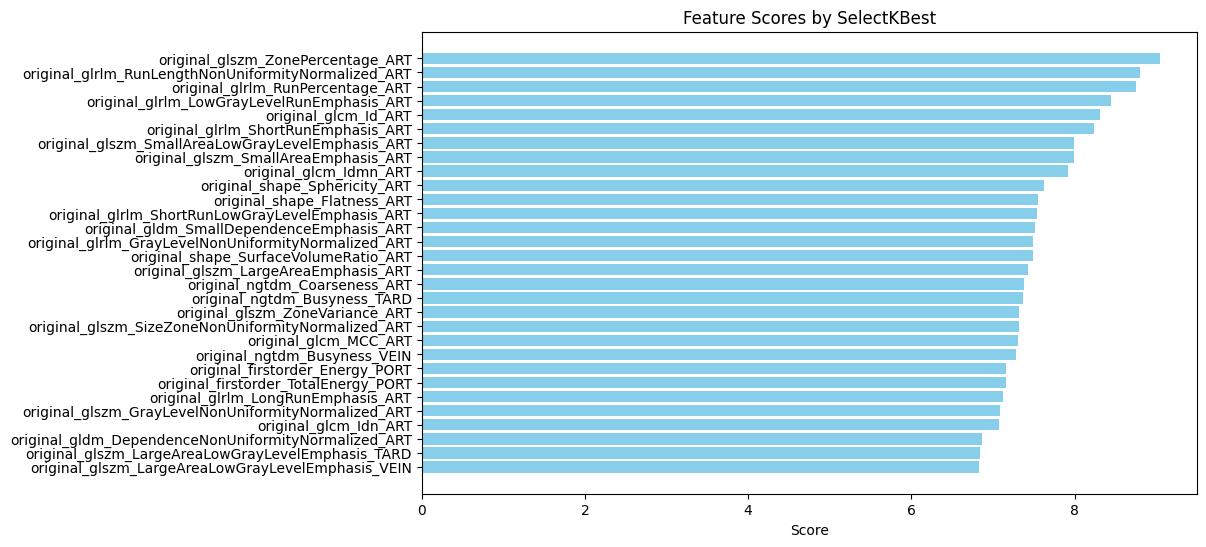

In [21]:
scores = selector.scores_[selector.get_support()]
feature_scores = pd.DataFrame({'Feature': selected_columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['Score'], color='skyblue')
plt.xlabel('Score')
plt.title('Feature Scores by SelectKBest')
plt.gca().invert_yaxis()
plt.show()

### Baseline Model

In [22]:
# Baseline
y_train_SMOTE.value_counts()

dead_after_one_year
False    78
True     78
Name: count, dtype: int64

## Model Benchmarks 
Here, we're simply running our models with no class adjustments and no hyper-parameter tuning. It's worth noting that <b>without feature engineering, our models performed substantially worse.</b> In iterations without feature engineering our Logistic Regression and AdaBoosting classifiers completely failed to identify any true positives.

In [23]:
init_list=[]

In [24]:
lr_1y = run_model('lr',mission='After one year')

### METRICS ###


{'model': 'lr',
 'mission': 'After one year',
 'train_auc': 0.7587113740959894,
 'test_auc': 0.6153846153846154,
 'precision': 0.17857142857142858,
 'specificity': 0.5576923076923077,
 'recall': 0.7142857142857143,
 'f_score': 0.2857142857142857}

True Negatives: 29
False Positives: 23
False Negatives: 2
True Positives: 5


In [25]:
dt_1y = run_model('dt',mission='After one year')

### METRICS ###


{'model': 'dt',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.456043956043956,
 'precision': 0.07692307692307693,
 'specificity': 0.7692307692307693,
 'recall': 0.14285714285714285,
 'f_score': 0.1}

True Negatives: 40
False Positives: 12
False Negatives: 6
True Positives: 1


In [26]:
rf_1y = run_model('rf',mission='After one year')

### METRICS ###


{'model': 'rf',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.3763736263736263,
 'precision': 0.09090909090909091,
 'specificity': 0.8076923076923077,
 'recall': 0.14285714285714285,
 'f_score': 0.1111111111111111}

True Negatives: 42
False Positives: 10
False Negatives: 6
True Positives: 1


In [27]:
gb_1y = run_model('gb',mission='After one year')

### METRICS ###


{'model': 'gb',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.36538461538461536,
 'precision': 0.1,
 'specificity': 0.8269230769230769,
 'recall': 0.14285714285714285,
 'f_score': 0.11764705882352941}

True Negatives: 43
False Positives: 9
False Negatives: 6
True Positives: 1


In [28]:
et_1y = run_model('et',mission='After one year')

### METRICS ###


{'model': 'et',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.39285714285714285,
 'precision': 0.09090909090909091,
 'specificity': 0.8076923076923077,
 'recall': 0.14285714285714285,
 'f_score': 0.1111111111111111}

True Negatives: 42
False Positives: 10
False Negatives: 6
True Positives: 1


In [29]:
svc_1y = run_model('svc',mission='After one year')

### METRICS ###


{'model': 'svc',
 'mission': 'After one year',
 'train_auc': 0.8089250493096647,
 'test_auc': 0.5233516483516484,
 'precision': 0.11764705882352941,
 'specificity': 0.7115384615384616,
 'recall': 0.2857142857142857,
 'f_score': 0.16666666666666666}

True Negatives: 37
False Positives: 15
False Negatives: 5
True Positives: 2


In [30]:
ada_1y = run_model('ada',mission='After one year')

### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'model': 'ada',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.6346153846153846,
 'precision': 0.13333333333333333,
 'specificity': 0.75,
 'recall': 0.2857142857142857,
 'f_score': 0.18181818181818182}

True Negatives: 39
False Positives: 13
False Negatives: 5
True Positives: 2


In [31]:
xg_1y = run_model('xgb',mission='After one year')

### METRICS ###


{'model': 'xgb',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.28846153846153844,
 'precision': 0.09090909090909091,
 'specificity': 0.8076923076923077,
 'recall': 0.14285714285714285,
 'f_score': 0.1111111111111111}

True Negatives: 42
False Positives: 10
False Negatives: 6
True Positives: 1


In [32]:
# Results of our initial modelling
pd.DataFrame(init_list).sort_values(by='test_auc', ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,ada,After one year,1.000000,0.634615,0.133333,0.750000,0.285714,0.181818
1,lr,After one year,0.758711,0.615385,0.178571,0.557692,0.714286,0.285714
2,svc,After one year,0.808925,0.523352,0.117647,0.711538,0.285714,0.166667
3,dt,After one year,1.000000,0.456044,0.076923,0.769231,0.142857,0.100000
4,et,After one year,1.000000,0.392857,0.090909,0.807692,0.142857,0.111111
5,rf,After one year,1.000000,0.376374,0.090909,0.807692,0.142857,0.111111
6,gb,After one year,1.000000,0.365385,0.100000,0.826923,0.142857,0.117647
7,xgb,After one year,1.000000,0.288462,0.090909,0.807692,0.142857,0.111111


In [33]:
y1_dict = {
    lr_1y: 'LogisticRegression',
    gb_1y: 'GradientBoostingClassifier',
    ada_1y: 'AdaBoostClassifier',
    rf_1y: 'RandomForest',
    svc_1y: 'SupportVectorMachineClf',
    et_1y: 'ExtraTreeClassifier',
    dt_1y: 'DecisionTreeClassifier',
    xg_1y:'XGBClassifier'
}

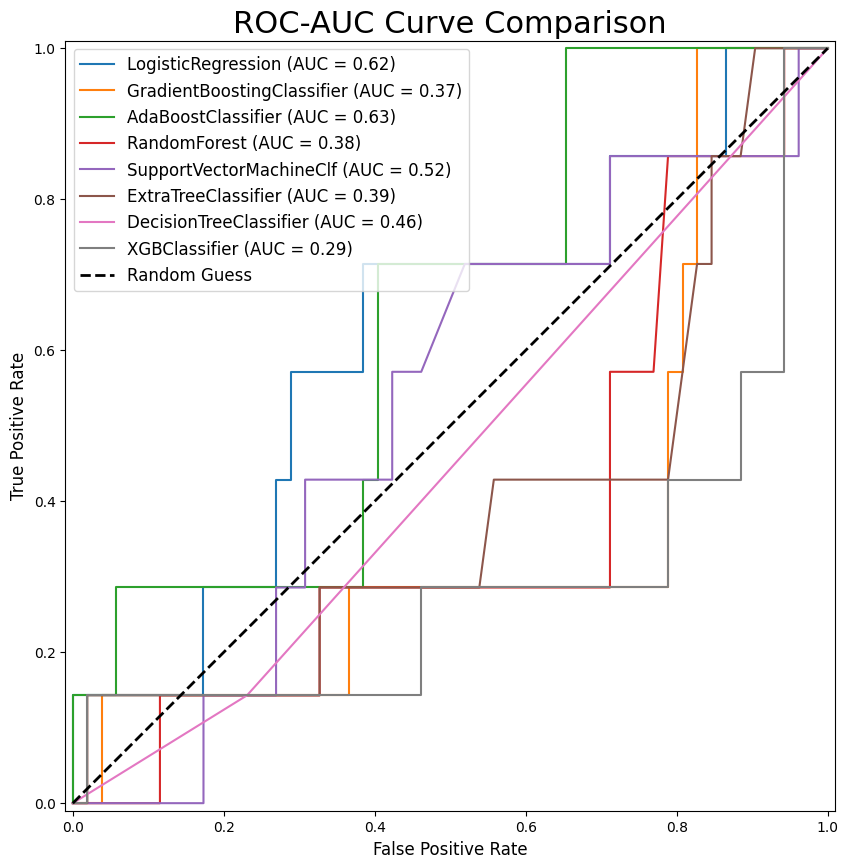

In [34]:
roc_curve_plotter(y1_dict)

### Hyperparameter selections

In [35]:
gs_list=[]

In [36]:
lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1', 'elasticnet'],

     # Trying different alphas of: 1, 0.1, 0.05  (C = 1/alpha)
    'lr__C':[1, 10, 20],
}

In [37]:
lr_gs_1 = run_model('lr',lr_params, mission='After one year',grid_search=True)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
9 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit

### BEST PARAMS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'lr__C': 20, 'lr__penalty': 'l2'}

### METRICS ###


{'model': 'lr',
 'mission': 'After one year',
 'train_auc': 0.7838593030900722,
 'test_auc': 0.6195054945054945,
 'precision': 0.17857142857142858,
 'specificity': 0.5576923076923077,
 'recall': 0.7142857142857143,
 'f_score': 0.2857142857142857}

True Negatives: 29
False Positives: 23
False Negatives: 2
True Positives: 5


In [38]:
dt_params = {'dt__max_depth': [20, 30, 40, 50],
             'dt__min_samples_split': [1, 5, 10, 15],
             'dt__min_samples_leaf': [2, 3, 4, 5],
             'dt__class_weight': ['balanced']}

In [39]:
dt_gs_1 = run_model('dt',mod_params=dt_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
### BEST PARAMS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
48 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.

{'dt__class_weight': 'balanced',
 'dt__max_depth': 20,
 'dt__min_samples_leaf': 4,
 'dt__min_samples_split': 5}

### METRICS ###


{'model': 'dt',
 'mission': 'After one year',
 'train_auc': 0.9953155818540435,
 'test_auc': 0.3337912087912087,
 'precision': 0.06666666666666667,
 'specificity': 0.7307692307692307,
 'recall': 0.14285714285714285,
 'f_score': 0.09090909090909091}

True Negatives: 38
False Positives: 14
False Negatives: 6
True Positives: 1


In [40]:
ada_params = {'ada__n_estimators': [500, 1000],
              'ada__learning_rate': [0.9, 1.0],
             }

In [41]:
ada_gs_1 = run_model('ada',mod_params=ada_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### BEST PARAMS ###


{'ada__learning_rate': 1.0, 'ada__n_estimators': 500}

### METRICS ###


{'model': 'ada',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.5686813186813187,
 'precision': 0.1,
 'specificity': 0.8269230769230769,
 'recall': 0.14285714285714285,
 'f_score': 0.11764705882352941}

True Negatives: 43
False Positives: 9
False Negatives: 6
True Positives: 1


In [42]:
gb_params = {'gb__n_estimators': [500, 1000],
             'gb__learning_rate': [0.4, 0.5, 0.6],
}

In [43]:
gb_gs_1 = run_model('gb',mod_params=gb_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
### BEST PARAMS ###


{'gb__learning_rate': 0.4, 'gb__n_estimators': 500}

### METRICS ###


{'model': 'gb',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.41758241758241754,
 'precision': 0.14285714285714285,
 'specificity': 0.8846153846153846,
 'recall': 0.14285714285714285,
 'f_score': 0.14285714285714285}

True Negatives: 46
False Positives: 6
False Negatives: 6
True Positives: 1


In [44]:
et_params = {'et__n_estimators': [20, 25, 30, 35],
             'et__max_depth': [20, 30, 40, 50],
             'et__min_samples_leaf': [2, 3, 4],
            }

In [45]:
et_gs_1 = run_model('et',mod_params=et_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
### BEST PARAMS ###


{'et__max_depth': 20, 'et__min_samples_leaf': 2, 'et__n_estimators': 30}

### METRICS ###


{'model': 'et',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.44368131868131866,
 'precision': 0.08333333333333333,
 'specificity': 0.7884615384615384,
 'recall': 0.14285714285714285,
 'f_score': 0.10526315789473684}

True Negatives: 41
False Positives: 11
False Negatives: 6
True Positives: 1


In [46]:
svc_params = {
    'svc__C':[10, 30],
    'svc__gamma':[0.01, 0.1], 
    'svc__kernel':['rbf', 'sigmoid'],
}

In [47]:
svc_gs_1 = run_model('svc',mod_params=svc_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
### BEST PARAMS ###


{'svc__C': 30, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

### METRICS ###


{'model': 'svc',
 'mission': 'After one year',
 'train_auc': 0.9648257725180802,
 'test_auc': 0.4409340659340659,
 'precision': 0.0625,
 'specificity': 0.7115384615384616,
 'recall': 0.14285714285714285,
 'f_score': 0.08695652173913043}

True Negatives: 37
False Positives: 15
False Negatives: 6
True Positives: 1


In [48]:
rf_params = {'rf__n_estimators': [20, 25, 30, 35],
             'rf__max_depth': [20, 30, 40, 50],
             'rf__min_samples_leaf': [2, 3, 4],
            }

In [49]:
rf_gs_1 = run_model('rf',mod_params=rf_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
### BEST PARAMS ###


{'rf__max_depth': 20, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 25}

### METRICS ###


{'model': 'rf',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.35027472527472525,
 'precision': 0.09090909090909091,
 'specificity': 0.8076923076923077,
 'recall': 0.14285714285714285,
 'f_score': 0.1111111111111111}

True Negatives: 42
False Positives: 10
False Negatives: 6
True Positives: 1


In [50]:
pd.DataFrame(gs_list).sort_values(by=['test_auc','mission'], ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,lr,After one year,0.783859,0.619505,0.178571,0.557692,0.714286,0.285714
1,ada,After one year,1.000000,0.568681,0.100000,0.826923,0.142857,0.117647
2,et,After one year,1.000000,0.443681,0.083333,0.788462,0.142857,0.105263
3,svc,After one year,0.964826,0.440934,0.062500,0.711538,0.142857,0.086957
4,gb,After one year,1.000000,0.417582,0.142857,0.884615,0.142857,0.142857
5,rf,After one year,1.000000,0.350275,0.090909,0.807692,0.142857,0.111111
6,dt,After one year,0.995316,0.333791,0.066667,0.730769,0.142857,0.090909


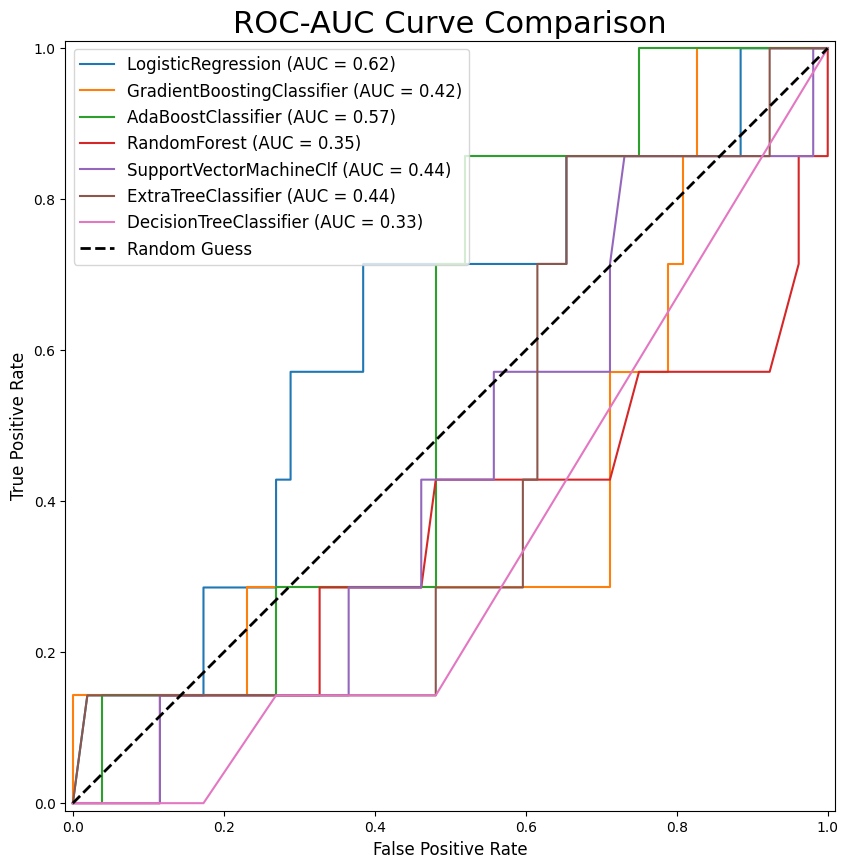

In [51]:
dict_hp_selected = {
    lr_gs_1: 'LogisticRegression',
    gb_gs_1: 'GradientBoostingClassifier',
    ada_gs_1: 'AdaBoostClassifier',
    rf_gs_1: 'RandomForest',
    svc_gs_1: 'SupportVectorMachineClf',
    et_gs_1: 'ExtraTreeClassifier',
    dt_gs_1: 'DecisionTreeClassifier',
}
roc_curve_plotter(dict_hp_selected)

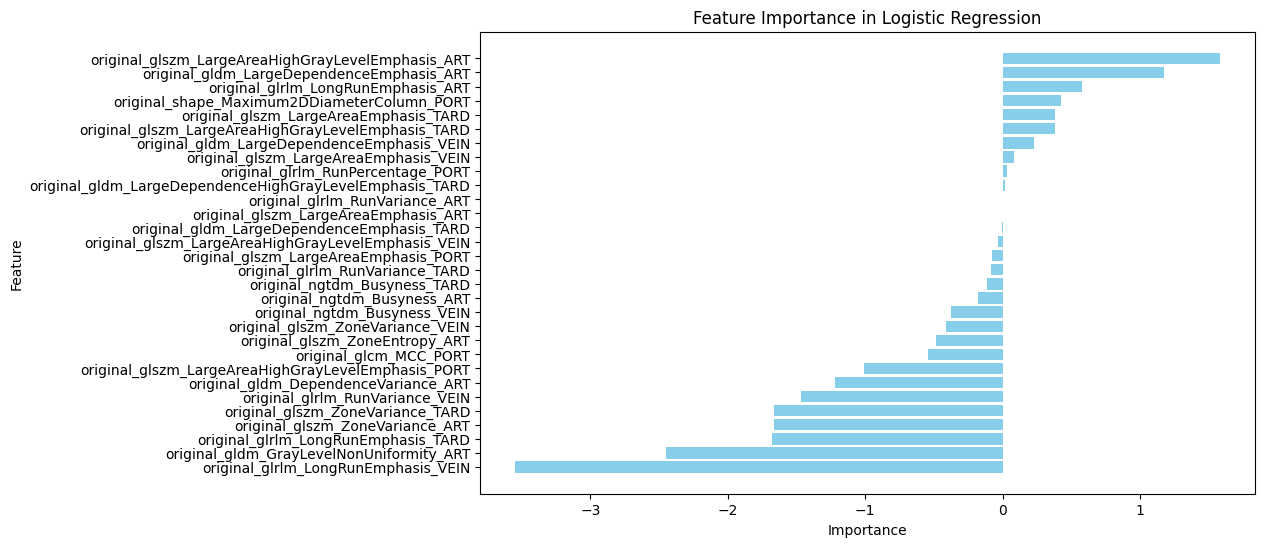

In [79]:
best_model = lr_gs_1.best_estimator_
feature_importances = best_model['lr'].coef_[0]  #feature_importances_
feature_names = X_train_selected_df.columns

feature_scores = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_scores = feature_scores.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

### Six years

In [53]:
y = data['dead_after_six_year']

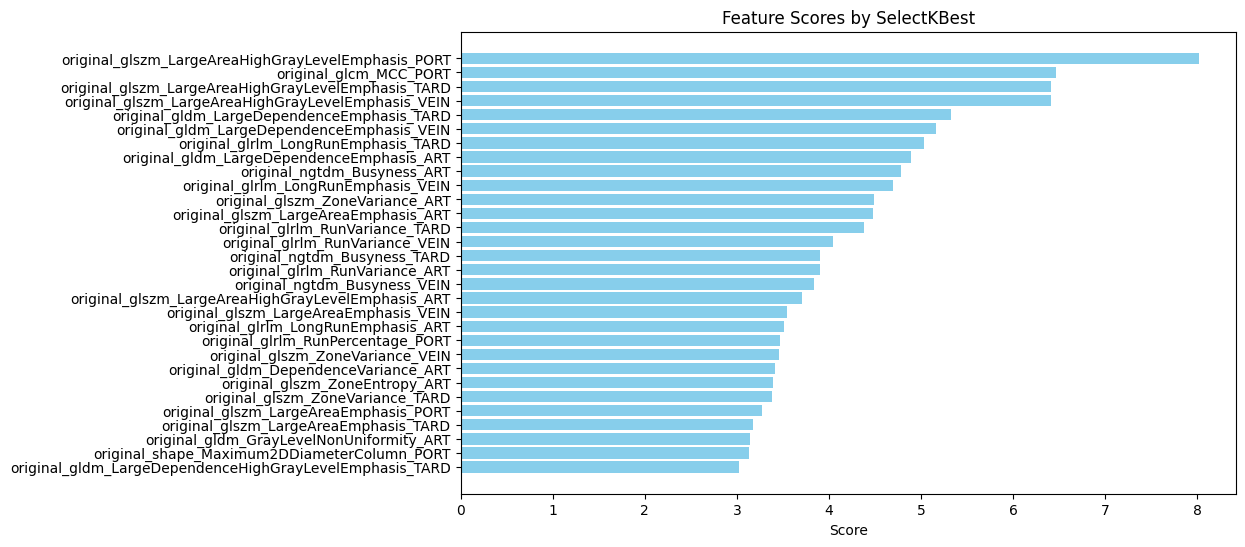

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X_original_col, y, test_size=0.3, stratify=y, random_state=42)

selector = SelectKBest(score_func=f_classif, k=30)
X_train_selected = selector.fit_transform(X_train_label, y_train_label)
X_test_selected = selector.transform(X_test_label)
selected_columns = X_original_col.columns[selector.get_support()]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_columns,index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_columns,index=X_test.index)

X_train_SMOTE, y_train_SMOTE = X_train_selected_df, y_train

scores = selector.scores_[selector.get_support()]
feature_scores = pd.DataFrame({'Feature': selected_columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['Score'], color='skyblue')
plt.xlabel('Score')
plt.title('Feature Scores by SelectKBest')
plt.gca().invert_yaxis()
plt.show()

In [55]:
y_train_SMOTE.value_counts()

dead_after_six_year
False    70
True     32
Name: count, dtype: int64

In [56]:
init_list=[]
lr_6y = run_model('lr',mission='After six years')
dt_6y = run_model('dt',mission='After six years')
rf_6y = run_model('rf',mission='After six years')
gb_6y = run_model('gb',mission='After six years')
et_6y = run_model('et',mission='After six years')
svc_6y = run_model('svc',mission='After six years')
ada_6y = run_model('ada',mission='After six years')
xg_6y = run_model('xgb',mission='After six years')

### METRICS ###


{'model': 'lr',
 'mission': 'After six years',
 'train_auc': 0.8366071428571428,
 'test_auc': 0.6682027649769586,
 'precision': 0.4,
 'specificity': 0.9032258064516129,
 'recall': 0.14285714285714285,
 'f_score': 0.21052631578947367}

True Negatives: 28
False Positives: 3
False Negatives: 12
True Positives: 2
### METRICS ###


{'model': 'dt',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.5426267281105991,
 'precision': 0.42857142857142855,
 'specificity': 0.8709677419354839,
 'recall': 0.21428571428571427,
 'f_score': 0.2857142857142857}

True Negatives: 27
False Positives: 4
False Negatives: 11
True Positives: 3
### METRICS ###


{'model': 'rf',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.6140552995391705,
 'precision': 0.5,
 'specificity': 0.9032258064516129,
 'recall': 0.21428571428571427,
 'f_score': 0.3}

True Negatives: 28
False Positives: 3
False Negatives: 11
True Positives: 3
### METRICS ###


{'model': 'gb',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.6405529953917051,
 'precision': 0.25,
 'specificity': 0.9032258064516129,
 'recall': 0.07142857142857142,
 'f_score': 0.1111111111111111}

True Negatives: 28
False Positives: 3
False Negatives: 13
True Positives: 1
### METRICS ###


{'model': 'et',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.5829493087557603,
 'precision': 0.6,
 'specificity': 0.9354838709677419,
 'recall': 0.21428571428571427,
 'f_score': 0.3157894736842105}

True Negatives: 29
False Positives: 2
False Negatives: 11
True Positives: 3
### METRICS ###


{'model': 'svc',
 'mission': 'After six years',
 'train_auc': 0.85625,
 'test_auc': 0.5737327188940093,
 'precision': 0.0,
 'specificity': 0.967741935483871,
 'recall': 0.0,
 'f_score': 0.0}

True Negatives: 30
False Positives: 1
False Negatives: 14
True Positives: 0
### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'model': 'ada',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.5668202764976958,
 'precision': 0.3076923076923077,
 'specificity': 0.7096774193548387,
 'recall': 0.2857142857142857,
 'f_score': 0.2962962962962963}

True Negatives: 22
False Positives: 9
False Negatives: 10
True Positives: 4
### METRICS ###


{'model': 'xgb',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.5783410138248848,
 'precision': 0.2857142857142857,
 'specificity': 0.8387096774193549,
 'recall': 0.14285714285714285,
 'f_score': 0.19047619047619047}

True Negatives: 26
False Positives: 5
False Negatives: 12
True Positives: 2


In [57]:
# Results of our initial modelling
pd.DataFrame(init_list).sort_values(by=['test_auc','mission'], ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,lr,After six years,0.836607,0.668203,0.400000,0.903226,0.142857,0.210526
1,gb,After six years,1.000000,0.640553,0.250000,0.903226,0.071429,0.111111
2,rf,After six years,1.000000,0.614055,0.500000,0.903226,0.214286,0.300000
3,et,After six years,1.000000,0.582949,0.600000,0.935484,0.214286,0.315789
4,xgb,After six years,1.000000,0.578341,0.285714,0.838710,0.142857,0.190476
5,svc,After six years,0.856250,0.573733,0.000000,0.967742,0.000000,0.000000
6,ada,After six years,1.000000,0.566820,0.307692,0.709677,0.285714,0.296296
7,dt,After six years,1.000000,0.542627,0.428571,0.870968,0.214286,0.285714


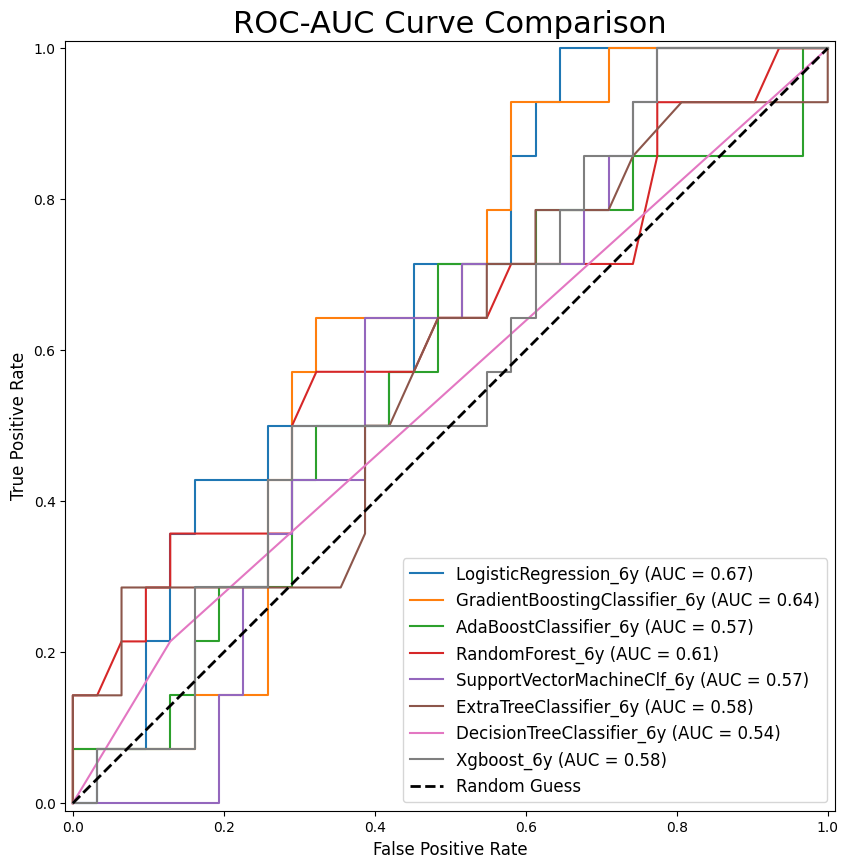

In [58]:
y6_dict = {
    lr_6y: 'LogisticRegression_6y',
    gb_6y: 'GradientBoostingClassifier_6y',
    ada_6y: 'AdaBoostClassifier_6y',
    rf_6y: 'RandomForest_6y',
    svc_6y: 'SupportVectorMachineClf_6y',
    et_6y: 'ExtraTreeClassifier_6y',
    dt_6y: 'DecisionTreeClassifier_6y',
    xg_6y:'Xgboost_6y'
}
roc_curve_plotter(y6_dict)

#### Hyperparameter selections

In [59]:
gs_list=[]

In [60]:
lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1', 'elasticnet'],

     # Trying different alphas of: 1, 0.1, 0.05  (C = 1/alpha)
    'lr__C':[1, 10, 20],
}

In [61]:
lr_gs = run_model('lr',lr_params, mission='After six years',grid_search=True)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
9 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit

### BEST PARAMS ###


{'lr__C': 20, 'lr__penalty': 'l1'}

### METRICS ###


{'model': 'lr',
 'mission': 'After six years',
 'train_auc': 0.8678571428571429,
 'test_auc': 0.5852534562211982,
 'precision': 0.16666666666666666,
 'specificity': 0.8387096774193549,
 'recall': 0.07142857142857142,
 'f_score': 0.1}

True Negatives: 26
False Positives: 5
False Negatives: 13
True Positives: 1


In [62]:
dt_params = {'dt__max_depth': [20, 30, 40, 50],
             'dt__min_samples_split': [1, 5, 10, 15],
             'dt__min_samples_leaf': [2, 3, 4, 5],
             'dt__class_weight': ['balanced']}

In [63]:
dt_gs = run_model('dt',mod_params=dt_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
### BEST PARAMS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
48 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.

{'dt__class_weight': 'balanced',
 'dt__max_depth': 20,
 'dt__min_samples_leaf': 4,
 'dt__min_samples_split': 15}

### METRICS ###


{'model': 'dt',
 'mission': 'After six years',
 'train_auc': 0.9515625,
 'test_auc': 0.6670506912442395,
 'precision': 0.5,
 'specificity': 0.8387096774193549,
 'recall': 0.35714285714285715,
 'f_score': 0.4166666666666667}

True Negatives: 26
False Positives: 5
False Negatives: 9
True Positives: 5


In [64]:
ada_params = {'ada__n_estimators': [500, 1000],
              'ada__learning_rate': [0.9, 1.0],
             }

In [65]:
ada_gs = run_model('ada',mod_params=ada_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### BEST PARAMS ###


{'ada__learning_rate': 0.9, 'ada__n_estimators': 500}

### METRICS ###


{'model': 'ada',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.5023041474654378,
 'precision': 0.4444444444444444,
 'specificity': 0.8387096774193549,
 'recall': 0.2857142857142857,
 'f_score': 0.34782608695652173}

True Negatives: 26
False Positives: 5
False Negatives: 10
True Positives: 4


In [66]:
gb_params = {'gb__n_estimators': [500, 1000],
             'gb__learning_rate': [0.4, 0.5, 0.6],
}

In [67]:
gb_gs = run_model('gb',mod_params=gb_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
### BEST PARAMS ###


{'gb__learning_rate': 0.4, 'gb__n_estimators': 500}

### METRICS ###


{'model': 'gb',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.6013824884792627,
 'precision': 0.2857142857142857,
 'specificity': 0.8387096774193549,
 'recall': 0.14285714285714285,
 'f_score': 0.19047619047619047}

True Negatives: 26
False Positives: 5
False Negatives: 12
True Positives: 2


In [68]:
et_params = {'et__n_estimators': [20, 25, 30, 35],
             'et__max_depth': [20, 30, 40, 50],
             'et__min_samples_leaf': [2, 3, 4],
            }

In [69]:
et_gs = run_model('et',mod_params=et_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
### BEST PARAMS ###


{'et__max_depth': 20, 'et__min_samples_leaf': 2, 'et__n_estimators': 35}

### METRICS ###


{'model': 'et',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.6152073732718893,
 'precision': 0.42857142857142855,
 'specificity': 0.8709677419354839,
 'recall': 0.21428571428571427,
 'f_score': 0.2857142857142857}

True Negatives: 27
False Positives: 4
False Negatives: 11
True Positives: 3


In [70]:
svc_params = {
    'svc__C':[10, 30],
    'svc__gamma':[0.01, 0.1], 
    'svc__kernel':['rbf', 'sigmoid'],
}

In [71]:
svc_gs = run_model('svc',mod_params=svc_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
### BEST PARAMS ###


{'svc__C': 30, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}

### METRICS ###


{'model': 'svc',
 'mission': 'After six years',
 'train_auc': 0.88125,
 'test_auc': 0.47235023041474655,
 'precision': 0.2,
 'specificity': 0.8709677419354839,
 'recall': 0.07142857142857142,
 'f_score': 0.10526315789473684}

True Negatives: 27
False Positives: 4
False Negatives: 13
True Positives: 1


In [72]:
rf_params = {'rf__n_estimators': [20, 25, 30, 35],
             'rf__max_depth': [20, 30, 40, 50],
             'rf__min_samples_leaf': [2, 3, 4],
            }

In [73]:
rf_gs = run_model('rf',mod_params=rf_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
### BEST PARAMS ###


{'rf__max_depth': 20, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 20}

### METRICS ###


{'model': 'rf',
 'mission': 'After six years',
 'train_auc': 0.99375,
 'test_auc': 0.6347926267281105,
 'precision': 0.5,
 'specificity': 0.9032258064516129,
 'recall': 0.21428571428571427,
 'f_score': 0.3}

True Negatives: 28
False Positives: 3
False Negatives: 11
True Positives: 3


In [74]:
pd.DataFrame(gs_list).sort_values(by=['test_auc','mission'], ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,dt,After six years,0.951562,0.667051,0.500000,0.838710,0.357143,0.416667
1,rf,After six years,0.993750,0.634793,0.500000,0.903226,0.214286,0.300000
2,et,After six years,1.000000,0.615207,0.428571,0.870968,0.214286,0.285714
3,gb,After six years,1.000000,0.601382,0.285714,0.838710,0.142857,0.190476
4,lr,After six years,0.867857,0.585253,0.166667,0.838710,0.071429,0.100000
5,ada,After six years,1.000000,0.502304,0.444444,0.838710,0.285714,0.347826
6,svc,After six years,0.881250,0.472350,0.200000,0.870968,0.071429,0.105263


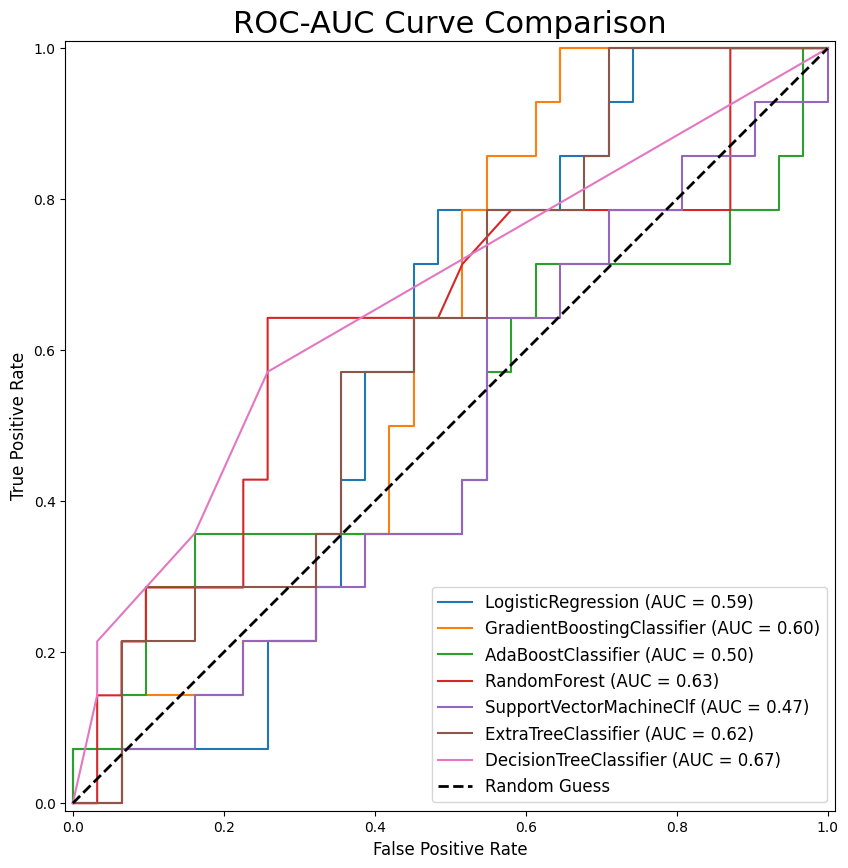

In [75]:
dict_hp_selected = {
    lr_gs: 'LogisticRegression',
    gb_gs: 'GradientBoostingClassifier',
    ada_gs: 'AdaBoostClassifier',
    rf_gs: 'RandomForest',
    svc_gs: 'SupportVectorMachineClf',
    et_gs: 'ExtraTreeClassifier',
    dt_gs: 'DecisionTreeClassifier',
}
roc_curve_plotter(dict_hp_selected)

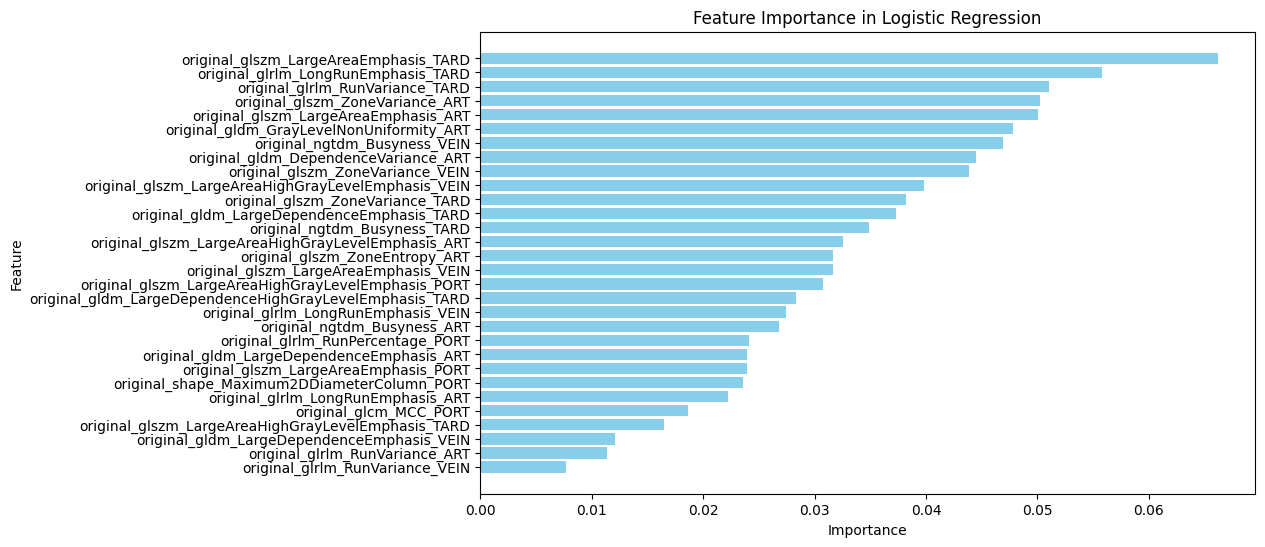

In [77]:
best_model = rf_gs.best_estimator_
feature_importances = best_model['rf'].feature_importances_   #feature_importances_
feature_names = X_train_selected_df.columns

feature_scores = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_scores = feature_scores.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()
plt.show()
